In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
import cmocean
from glob import glob
import gsw

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def get_dist(y,m, lon0=None,lat0=None):
    '''Get distance between moorings for given year/month'''
    c = 2 if y>2002 else 1 # index of column with mooring numbers 
    info = pd.read_csv(join(fp, f'{y}{m}.sum'),skiprows=[0,1,2,3,4],sep='\s+',header=None,on_bad_lines='warn')
    info = info.loc[info.iloc[:,c+5]=='BO']
    info = info[~info.iloc[:,c].duplicated(keep='first')] # remove duplicates...
    locs = pd.unique(info.iloc[:,c])
    lat = (info.loc[:,c+6].values + info.loc[:,c+7].values/60)
    lon = -(info.loc[:,c+9].values + info.loc[:,c+10].values/60)
    lonlat = zip(lon,lat)
    if lon0 is None:
        dist = [haversine_np(lon[0],lat[0], x2, y2) for (x2,y2) in lonlat]
    else:
        dist = [haversine_np(lon0,lat0, x2, y2) for (x2,y2) in lonlat]
    return dist, (lon, lat), locs

def check_index(ds, name='p'):
    '''check dataset/array index for duplicates, and drop them '''
    _, idx = np.unique(ds[name], return_index=True)
    return ds.isel({name:idx})

def read_year_month(y, m, lon0=None, lat0=None, p_interp=None, d_interp=None):
    dist, (lon,lat), locs = get_dist(y,m, lon0=lon0, lat0=lat0)
    data = []
    for loc in locs:
        f = f'{y}{m}_{loc}.ctd'
        d = pd.read_csv(join(fp,f), skiprows=[0,1,2,4,5], sep='\s+').set_index('CTDPRS')
        d = d.to_xarray().rename({'CTDPRS':'p', 'CTDTMP':'T','CTDSAL':'S'})[['T','S']]
        d = check_index(d, name='p') # check for duplicate pressure coordinates...
        data.append(d)
    data = xr.concat(data, dim = pd.Index(locs, name='loc'))
    data = data.rename({'loc':'dist'}).assign({'dist':dist})
    if p_interp is not None:
        data = data.interp({'p':p_interp})
        data = data.interp({'dist':d_interp})
    return data

# Load CTD data

In [2]:
interp = False # whether to use (heavy) interpolation
fp = 'line-w/ctd'
fp2= 'line-w/adcp'

# get list of months that match between adcp and ctd
l1 = [x[12:19] for x in glob(join(fp2, '*.zip'))]
l2 = [x[11:18] for x in glob(join(fp,  '*.zip'))]
l  = list(set(l1).intersection(l2))
valid_times = sorted([(int(x[:4]), x[4:]) for x in l])[::-1] # get valid times from data
month_idx   = [10,10,5,4,10,4,10,4,10,5,9,10,7,8,5,5][::-1]  # numerical indices of months
time_idx    = pd.DatetimeIndex([datetime(x[0],m,15) for (x,m) in zip(valid_times,month_idx)],name='time') # index to use for labeling

dist, (lon,lat), labels = get_dist(2014,'may')
# Interpolation grid
if interp:
    delta_p  = 1.6e3 / 160
    delta_d  = 1000  / 50
    d_interp = np.arange(0,1000  + delta_d,    delta_d)
else:
    delta_p  = 2    # this is native pressure resolution for CTD data
#     d_interp = np.array(dist)
    delta_d  = 1000  / 50
    d_interp = np.arange(0,1000  + delta_d,    delta_d)
p_interp = np.arange(0,1.6e3 + delta_p,    delta_p) # pressure coordinate

#### Get data
data = []
for y,m in valid_times:
    data.append(read_year_month(y,m, p_interp = p_interp, d_interp=d_interp, lon0=lon[0], lat0=lat[0]))
data = xr.concat(data, dim=time_idx)
data = data.isel(time=np.concatenate([np.arange(11), np.array([12,13])])) # select "good" years

b'Skipping line 51: expected 20 fields, saw 25\n'
b'Skipping line 9: expected 19 fields, saw 20\nSkipping line 12: expected 19 fields, saw 20\nSkipping line 15: expected 19 fields, saw 20\nSkipping line 21: expected 19 fields, saw 20\nSkipping line 24: expected 19 fields, saw 20\nSkipping line 27: expected 19 fields, saw 20\nSkipping line 30: expected 19 fields, saw 20\nSkipping line 33: expected 19 fields, saw 20\nSkipping line 36: expected 19 fields, saw 20\nSkipping line 39: expected 19 fields, saw 20\nSkipping line 42: expected 19 fields, saw 20\nSkipping line 45: expected 19 fields, saw 20\nSkipping line 48: expected 19 fields, saw 20\nSkipping line 51: expected 19 fields, saw 20\n'
b'Skipping line 14: expected 19 fields, saw 25\nSkipping line 17: expected 19 fields, saw 24\n'


# Compute density

In [3]:
# Create array with size matching CTD data; fill with lon/lat/pressure values for GSW calculations
mt_array  = np.ones_like(data['S'])
lon_interp, lat_interp = [np.linspace(l[0], l[-1], len(data['dist'])) for l in [lon,lat]] # interpolate lat/lon to match data
p_array   = data['p'].values[None,None,:] * mt_array
lon_array = lon_interp[None,:,None]       * mt_array
lat_array = lat_interp[None,:,None]       * mt_array

# Convert practical sal. to absolute sal., and temperature to conservative temperature
S_abs       = gsw.SA_from_SP(SP = data['S'], p = p_array, lon=lon_array, lat=lat_array) # absolute salinity
T_con       = gsw.CT_from_t( SA = S_abs,     p = p_array, t = data['T']) # conservative temp.
# data['rho'] = gsw.rho(SA=S_abs, CT=T_con, p=p_array)
data['rho'] = gsw.sigma0(SA=S_abs, CT=T_con)

# Plot

## Density

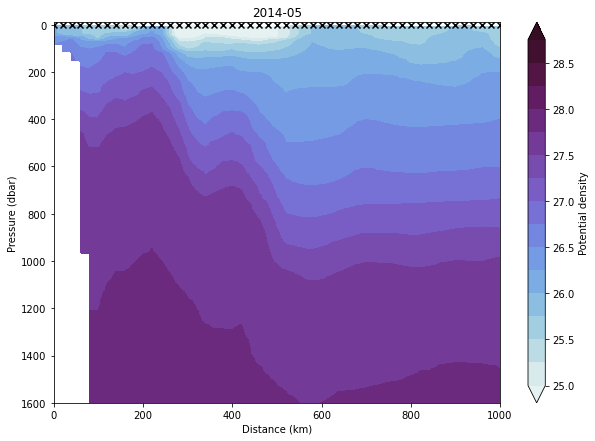

In [4]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.p, data.isel(time=i)['rho'].T, cmap='cmo.dense',
               levels=np.arange(25,29,.25), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Potential density') # create colorbar
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

## Temperature

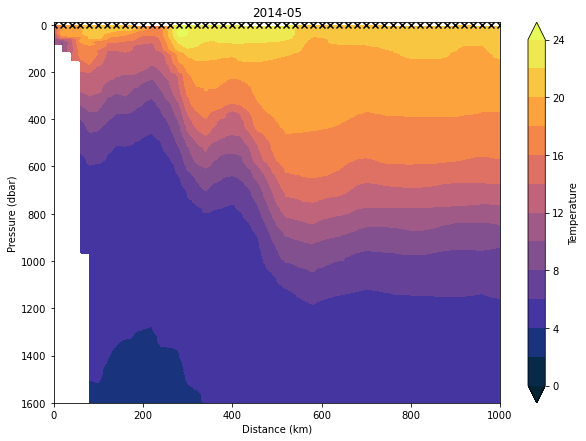

In [5]:
i = 0 # time index to plot
fig, ax = plt.subplots(figsize=(10,7)) # create canvas for plotting
p = ax.contourf(data.dist, data.p, data.isel(time=i)['T'].T, cmap='cmo.thermal',
               levels=np.arange(0,25,2), extend='both') # create contour plot
ax.scatter(data.dist, np.zeros(len(data.dist)),marker='x', color='k')
cb = fig.colorbar(p, orientation='vertical', label=r'Temperature') # create colorbar
ax.set_ylabel('Pressure (dbar)')
ax.set_xlabel('Distance (km)')
ax.set_ylim([-10,1600])
time = data.time.isel(time=i)
y    = time.dt.year.values.item()
m    = time.dt.month.values.item()
ax.set_title(f'{y}-{m:02d}')
plt.gca().invert_yaxis() # reverse order of y axis so that depth decreases going down
plt.show()

## Plot cross section

Compute angle of line w

In [5]:
dlon1 = haversine_np(lon[0],lat[0],lon[-1],lat[0])
dlon2 = haversine_np(lon[0],lat[-1],lon[-1],lat[-1])
dlat  = haversine_np(lon[0],lat[0],lon[1],lat[-1])
dlon = (dlon2+dlon1)/2

# Get projection matrix (for rotating u/v vectors)
P = np.array([[dlon, -dlat],[dlat, dlon]])
P /= np.sqrt(dlon**2 + dlat**2)
uv = np.array([1,0])[:,None]

mag = 3
e1  = mag*np.array([1,0])[:,None]
e2  = mag*np.array([0,1])[:,None]

e1hat = np.linalg.inv(P)@e1
e2hat = np.linalg.inv(P)@e2

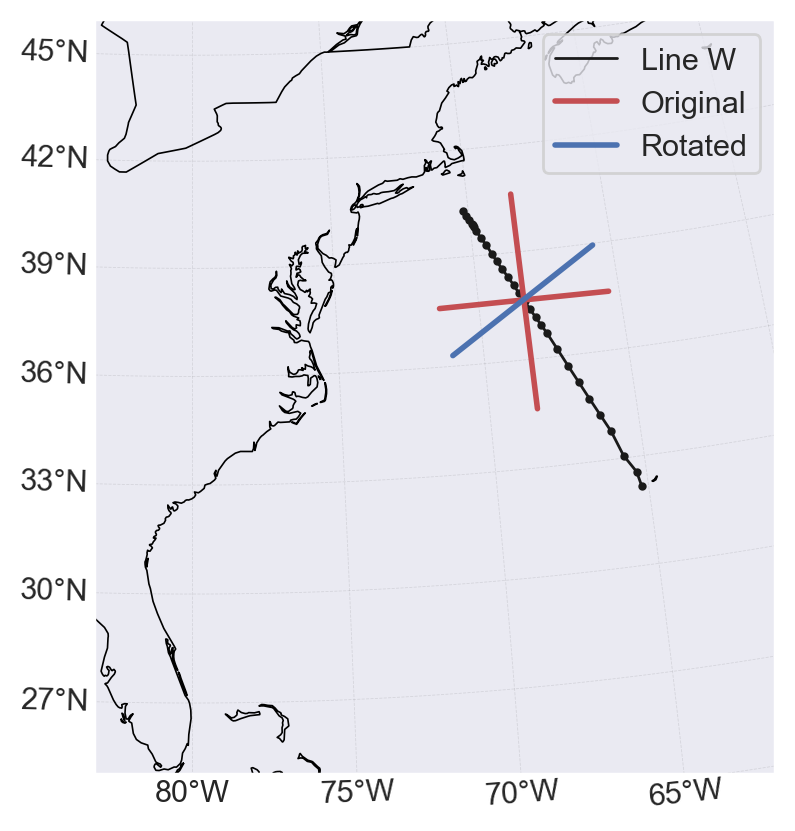

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set()

plot_range=[-83,-62,25,45]
central_lon=-80
central_lat=30
fig = plt.figure(figsize = (7,5))                                       
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=central_lon, 
                                           central_latitude=central_lat)) # Use map background
ax.set_extent(plot_range, crs=ccrs.PlateCarree())
ax.coastlines(linewidth=.6) 
ax.add_feature(cfeature.BORDERS, zorder=1, linewidth=.6)
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=.1, linewidth=.3, color='k', zorder=1.05)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

### Plot Line W
ax.scatter(lon, lat, transform=ccrs.PlateCarree(), s=4, c='k')
ax.plot(lon, lat, transform=ccrs.PlateCarree(), lw=1,c='k', label='Line W')

# Plot pythagorean triangle
# ax.plot([lon[0],lon[-1]], [lat[-1],lat[-1]], transform=ccrs.PlateCarree(), lw=.5,c='r')
# ax.plot([lon[0],lon[0]], [lat[-1],lat[0]], transform=ccrs.PlateCarree(), lw=.5,c='r')

### Plot coordinates
x_ = np.array([lon[15],lat[15]])
for i,e in enumerate([e1.flatten(),e2.flatten()]):
    ax.plot([x_[0]-e[0],x_[0]+e[0].item()], [x_[1]-e[1],x_[1]+e[1].item()], 
            transform=ccrs.PlateCarree(), lw=2,c='r', label='Original' if i==0 else None)
for e in [e2hat.flatten()]:
    ax.plot([x_[0]-e[0],x_[0]+e[0]], [x_[1]-e[1],x_[1]+e[1].item()], 
            transform=ccrs.PlateCarree(), lw=2,c='b', label='Rotated')
ax.legend()
plt.show()

In [7]:
lat

array([40.283     , 40.14      , 40.0115    , 39.89916667, 39.85866667,
       39.79133333, 39.70033333, 39.47416667, 39.26683333, 39.01416667,
       38.79033333, 38.5595    , 38.3315    , 38.10066667, 37.85083333,
       37.62233333, 37.38616667, 37.14516667, 36.90333333, 36.663     ,
       36.199     , 35.70966667, 35.22733333, 34.74      , 34.25983333,
       33.77816667, 33.068     , 32.58316667, 32.1625    ])

# Save to file

In [4]:
data.to_netcdf('ctd-data_no-interp.nc')